<a href="https://colab.research.google.com/github/mziad97/Frog-v-Giraffe/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import urllib.request
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile

In [ ]:
! pip install -q kaggle

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [67]:
print("the number of frog instances: {}".format( len(os.listdir('./frog'))))
print("The numebr of giraffe instances: {}".format(len(os.listdir('./giraffe'))))

the number of frog instances: 116
the numebr of giraffe instances: 84


In [91]:
  os.mkdir('./frog-v-giraffe')
  os.mkdir('./frog-v-giraffe/training')
  os.mkdir('./frog-v-giraffe/testing')
  os.mkdir('./frog-v-giraffe/training/frog')
  os.mkdir('./frog-v-giraffe/training/giraffe')
  os.mkdir('./frog-v-giraffe/testing/frog')
  os.mkdir('./frog-v-giraffe/testing/giraffe')

In [92]:
import random
from shutil import copyfile

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
  files = []
  for filename in os.listdir(SOURCE):
    file = SOURCE + filename
    if (os.path.getsize(file) > 0):
      files.append(filename)
    else:
      print(f'{filename} is empty')


  train_length = int(len(files) * SPLIT_SIZE)
  test_length = int(len(files) - train_length)
  shuffled_set = random.sample(files, len(files))
  train_set = shuffled_set[0:train_length]
  test_set = shuffled_set[train_length:]

  for filename in train_set:
    this_file = SOURCE + filename
    destination = TRAINING + filename
    copyfile(this_file, destination)

  for filename in test_set:
    this_file = SOURCE + filename
    destination = TESTING + filename
    copyfile(this_file, destination)

In [95]:
FROG_SOURCE_DIR = "./frog/"
TRAINING_FROG_DIR = "./frog-v-giraffe/training/frog/"
TESTING_FROG_DIR = "./frog-v-giraffe/testing/frog/"
GIRAFFE_SOURCE_DIR = "./giraffe/"
TRAINING_GIRAFFE_DIR = "./frog-v-giraffe/training/giraffe/"
TESTING_GIRAFFE_DIR = "./frog-v-giraffe/testing/giraffe/"

split_size = .80
split_data(FROG_SOURCE_DIR, TRAINING_FROG_DIR, TESTING_FROG_DIR, split_size)
split_data(GIRAFFE_SOURCE_DIR, TRAINING_GIRAFFE_DIR, TESTING_GIRAFFE_DIR, split_size)

In [98]:
print(f'frog training number: { len(os.listdir("./frog-v-giraffe/training/frog")) }')
print(f'frog testing numebr: { len(os.listdir("./frog-v-giraffe/testing/frog")) }')
print(f'giraffe training number: { len(os.listdir("./frog-v-giraffe/training/giraffe")) }')
print(f'giraffe testing number: { len(os.listdir("./frog-v-giraffe/testing/giraffe")) }')

frog training number: 102
frog testing numebr: 14
giraffe training number: 73
giraffe testing number: 11


# Data Augmentation

In [111]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = "./frog-v-giraffe/training"
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR, batch_size=20,
                                                    class_mode='binary', target_size=(150, 150))

VALIDATION_DIR = "./frog-v-giraffe/testing"
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(VALIDATION_DIR, class_mode='binary', target_size=(150, 150))

Found 175 images belonging to 2 classes.
Found 25 images belonging to 2 classes.


In [100]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

pre_trained_model = InceptionV3(input_shape=(150,150,3), 
                                include_top=False,
                                weights=None)

pre_trained_model.load_weights(weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False


In [123]:
#pre_trained_model.summary()

In [119]:
last_layer = pre_trained_model.get_layer('mixed4')
print("last layer shape: ", last_layer.output_shape)
last_output = last_layer.output

last layer shape:  (None, 7, 7, 768)


## adding layers

In [120]:
x = layers.Flatten()(last_output)
x = layers.Dense(1080, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

In [121]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(train_generator, validation_data=valid_generator, epochs= 10, verbose=1)

Epoch 1/10
9/9 [==============================] - 14s 1s/step - loss: 2.1314 - acc: 0.5771 - val_loss: 0.4423 - val_acc: 0.7600
Epoch 2/10
9/9 [==============================] - 10s 1s/step - loss: 0.6545 - acc: 0.6743 - val_loss: 0.5174 - val_acc: 0.7200
Epoch 3/10
9/9 [==============================] - 10s 1s/step - loss: 0.4385 - acc: 0.7714 - val_loss: 0.4391 - val_acc: 0.7200
Epoch 4/10
9/9 [==============================] - 10s 1s/step - loss: 0.3747 - acc: 0.8343 - val_loss: 0.4162 - val_acc: 0.7600
Epoch 5/10
9/9 [==============================] - 10s 1s/step - loss: 0.4438 - acc: 0.7886 - val_loss: 0.1439 - val_acc: 0.9600
Epoch 6/10
9/9 [==============================] - 10s 1s/step - loss: 0.1799 - acc: 0.9029 - val_loss: 0.0774 - val_acc: 0.9600
Epoch 7/10
9/9 [==============================] - 10s 1s/step - loss: 0.5444 - acc: 0.7771 - val_loss: 0.0959 - val_acc: 1.0000
Epoch 8/10
9/9 [==============================] - 10s 1s/step - loss: 0.2166 - acc: 0.9143 - val_loss: 0

<Figure size 432x288 with 0 Axes>

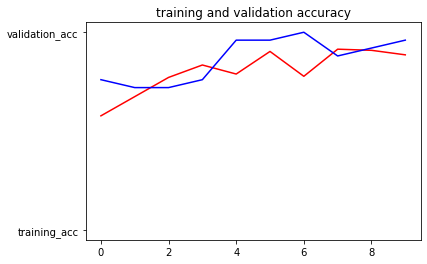

<Figure size 432x288 with 0 Axes>

In [122]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', 'training_acc')
plt.plot(epochs, val_acc, 'b', 'validation_acc')
plt.title("training and validation accuracy")
plt.figure()